In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys

# Set the device to GPU if avalable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations for training and validation
transform_train = transforms.Compose([
    # To perform some imaage augmentation
    transforms.RandomCrop(32, padding=4),  # To randomly crop and pad images
    transforms.RandomHorizontalFlip(),     # to randomly flip images horizontally
    transforms.ToTensor(),                 # To convert images to tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # To normalize with optimal values of mean and std for CIFAR 10 from https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# Load CIFAR 10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


100%|██████████| 170M/170M [00:02<00:00, 80.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:

# Size of Training dataset
print("Train dataset size: ",len(train_dataset))

# Size of Testing dataset
print("\nTest dataset size: ",len(test_dataset))

# Split train dataset into 80% training and 20% validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Size of Training dataset after splitting to Traning and Validation datasets
print("\nTrain dataset size after splitting: ",train_size)

# Size of Validation dataset
print("\nValidation dataset size: ",val_size)

# To define data loaders for training, validation, and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Train dataset size:  50000

Test dataset size:  10000

Train dataset size after splitting:  40000

Validation dataset size:  10000


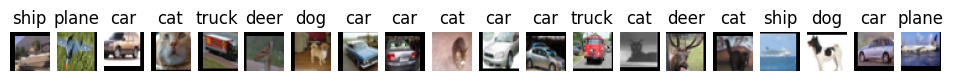

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# CIFAR 10 class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Function to unnormalize the image
def unnormalize(image, mean, std):
    image = image.clone()  # Clone to avoid modifying the original tensor
    for c in range(3):     # Apply unnormalization for each color channel
        image[c] = image[c]*std[c] + mean[c]
    return image

# Function to display a grid of images with their labels
def show_random_samples(train_loader, classes, num_samples=20):
    # Get a batch of images and labels
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    # Select random indices from the batch
    indices = np.random.choice(range(len(images)), num_samples, replace=False)

    # Mean and std used for normalization (from CIFAR 10 transform)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2470, 0.2435, 0.2616)

    # Plot the selected images with their corresponding labels
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    for i, idx in enumerate(indices):
        image, label = images[idx], labels[idx]

        # Unnormalize the image
        image = unnormalize(image, mean, std)

        # Convert the tensor image to numpy for displaying
        np_image = image.numpy().transpose((1,2,0))  # Change channel order for plt.imshow
        np_image = np.clip(np_image,0,1)  # To ensure values are within [0, 1]

        axes[i].imshow(np_image)
        axes[i].set_title(classes[label])
        axes[i].axis('off')

    plt.show()

# To display samples from the train_loader
show_random_samples(train_loader, classes)

In [ ]:

# To define a class for ResNet 18 model as the base model with Residual blocks

# Define the basic residual block used in ResNet18
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # To define shortcut (residual connection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

# Define ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Define layers using the BasicBlock
        self.layer1 = self._make_layer(64, 64, stride=1, num_blocks=2)
        self.layer2 = self._make_layer(64, 128, stride=2, num_blocks=2)
        self.layer3 = self._make_layer(128, 256, stride=2, num_blocks=2)
        self.layer4 = self._make_layer(256, 512, stride=2, num_blocks=2)

        # Global average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolutional layer
        out = self.conv1(x)

        # Residual layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Global average pooling and flatten
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        # Fully connected layer
        out = self.fc(out)
        return out

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)
print(resnet18_base_model)

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, ker

In [ ]:
# Training ResNet 18 Model Phase 1 with SGD optimizer and 0.01 learning rate

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_base_model.parameters(), lr=lr)

epoch_num = 30

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 1.6276, Val Loss: 1.6033, Train Acc: 0.3958, Val Acc: 0.4427
Epoch 2/30, Train Loss: 1.2690, Val Loss: 1.1844, Train Acc: 0.5396, Val Acc: 0.5819
Epoch 3/30, Train Loss: 1.0699, Val Loss: 1.1266, Train Acc: 0.6158, Val Acc: 0.6042
Epoch 4/30, Train Loss: 0.9473, Val Loss: 0.9565, Train Acc: 0.6612, Val Acc: 0.6624
Epoch 5/30, Train Loss: 0.8555, Val Loss: 0.8741, Train Acc: 0.6964, Val Acc: 0.6962
Epoch 6/30, Train Loss: 0.7724, Val Loss: 0.8081, Train Acc: 0.7268, Val Acc: 0.7222
Epoch 7/30, Train Loss: 0.7092, Val Loss: 0.8084, Train Acc: 0.7505, Val Acc: 0.7161
Epoch 8/30, Train Loss: 0.6546, Val Loss: 0.7315, Train Acc: 0.7702, Val Acc: 0.7471
Epoch 9/30, Train Loss: 0.6090, Val Loss: 0.7387, Train Acc: 0.7869, Val Acc: 0.7487
Epoch 10/30, Train Loss: 0.5661, Val Loss: 0.7322, Train Acc: 0.8029, Val Acc: 0.7508
Epoch 11/30, Train Loss: 0.5333, Val Loss: 0.6428, Train Acc: 0.8157, Val Acc: 0.7802
Epoch 12/30, Train Loss: 0.5011, Val Loss: 0.6298, Train Acc: 0

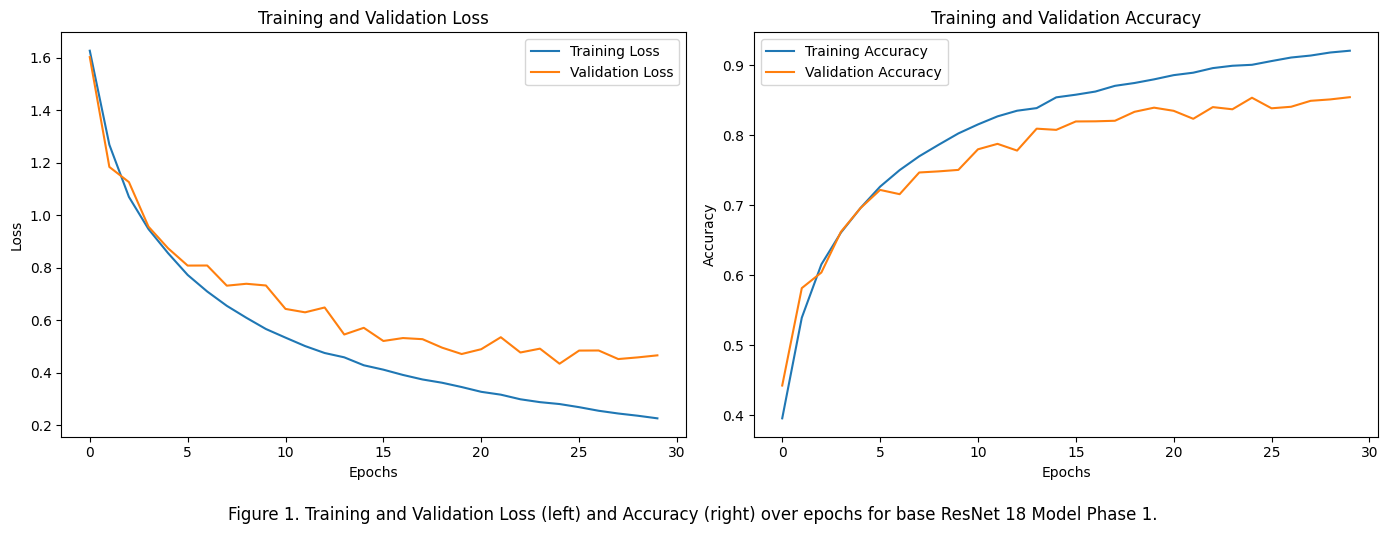

In [ ]:

# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 1. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 1. ",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_1.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_1.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'optimizer': 'SGD',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_1.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_1.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 2 with SGD optimizer and 0.001 learning rate

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_base_model.parameters(), lr=lr)

epoch_num = 60

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 2.0740, Val Loss: 1.9039, Train Acc: 0.2338, Val Acc: 0.2992
Epoch 2/60, Train Loss: 1.7880, Val Loss: 1.7030, Train Acc: 0.3428, Val Acc: 0.3715
Epoch 3/60, Train Loss: 1.6468, Val Loss: 1.5993, Train Acc: 0.3950, Val Acc: 0.4105
Epoch 4/60, Train Loss: 1.5664, Val Loss: 1.5451, Train Acc: 0.4219, Val Acc: 0.4371
Epoch 5/60, Train Loss: 1.5006, Val Loss: 1.4707, Train Acc: 0.4489, Val Acc: 0.4647
Epoch 6/60, Train Loss: 1.4471, Val Loss: 1.4207, Train Acc: 0.4707, Val Acc: 0.4826
Epoch 7/60, Train Loss: 1.4046, Val Loss: 1.3855, Train Acc: 0.4880, Val Acc: 0.4951
Epoch 8/60, Train Loss: 1.3609, Val Loss: 1.3439, Train Acc: 0.5042, Val Acc: 0.5173
Epoch 9/60, Train Loss: 1.3249, Val Loss: 1.3311, Train Acc: 0.5184, Val Acc: 0.5152
Epoch 10/60, Train Loss: 1.2923, Val Loss: 1.2935, Train Acc: 0.5314, Val Acc: 0.5286
Epoch 11/60, Train Loss: 1.2681, Val Loss: 1.2763, Train Acc: 0.5403, Val Acc: 0.5414
Epoch 12/60, Train Loss: 1.2367, Val Loss: 1.2450, Train Acc: 0

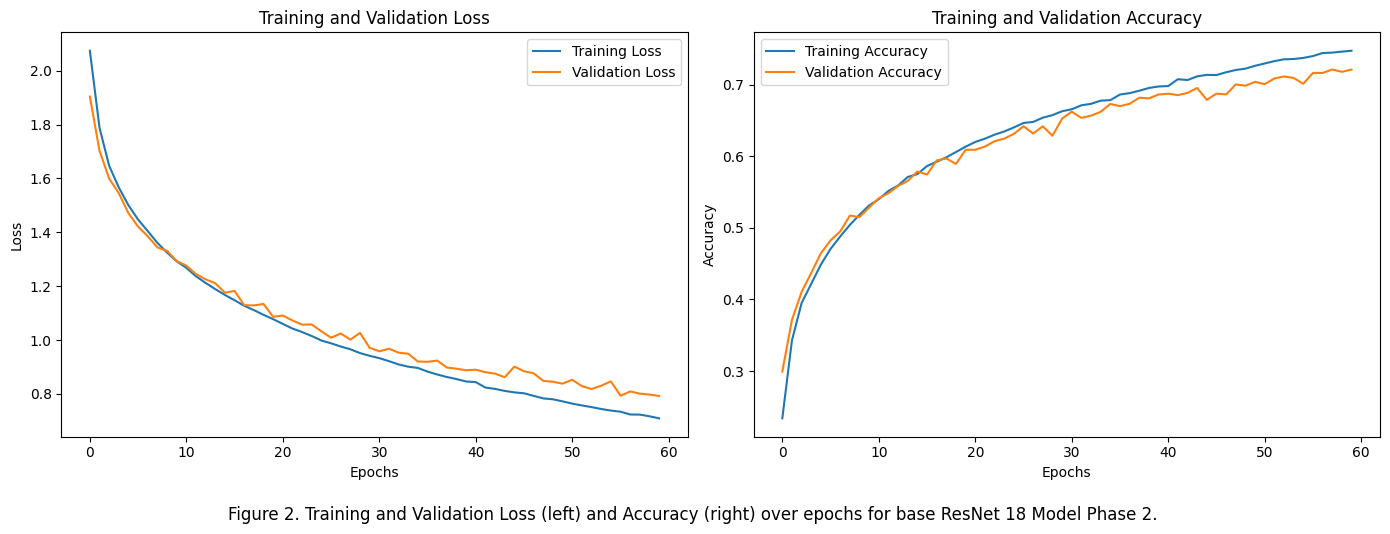

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 2. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 2. ",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_2.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_2.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'optimizer': 'SGD',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_2.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_2.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 3 with Adam optimizer and 0.01 learning rate

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_base_model.parameters(), lr=lr)

epoch_num = 30

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 1.8766, Val Loss: 1.5768, Train Acc: 0.3075, Val Acc: 0.4217
Epoch 2/30, Train Loss: 1.4263, Val Loss: 1.3201, Train Acc: 0.4792, Val Acc: 0.5295
Epoch 3/30, Train Loss: 1.1235, Val Loss: 1.0430, Train Acc: 0.5956, Val Acc: 0.6350
Epoch 4/30, Train Loss: 0.9383, Val Loss: 0.9547, Train Acc: 0.6660, Val Acc: 0.6672
Epoch 5/30, Train Loss: 0.7853, Val Loss: 0.7672, Train Acc: 0.7246, Val Acc: 0.7365
Epoch 6/30, Train Loss: 0.6702, Val Loss: 0.7369, Train Acc: 0.7673, Val Acc: 0.7470
Epoch 7/30, Train Loss: 0.5856, Val Loss: 0.5780, Train Acc: 0.7962, Val Acc: 0.7981
Epoch 8/30, Train Loss: 0.5270, Val Loss: 0.5896, Train Acc: 0.8174, Val Acc: 0.7971
Epoch 9/30, Train Loss: 0.4826, Val Loss: 0.4910, Train Acc: 0.8315, Val Acc: 0.8312
Epoch 10/30, Train Loss: 0.4394, Val Loss: 0.4777, Train Acc: 0.8483, Val Acc: 0.8415
Epoch 11/30, Train Loss: 0.4128, Val Loss: 0.4698, Train Acc: 0.8554, Val Acc: 0.8431
Epoch 12/30, Train Loss: 0.3776, Val Loss: 0.5536, Train Acc: 0

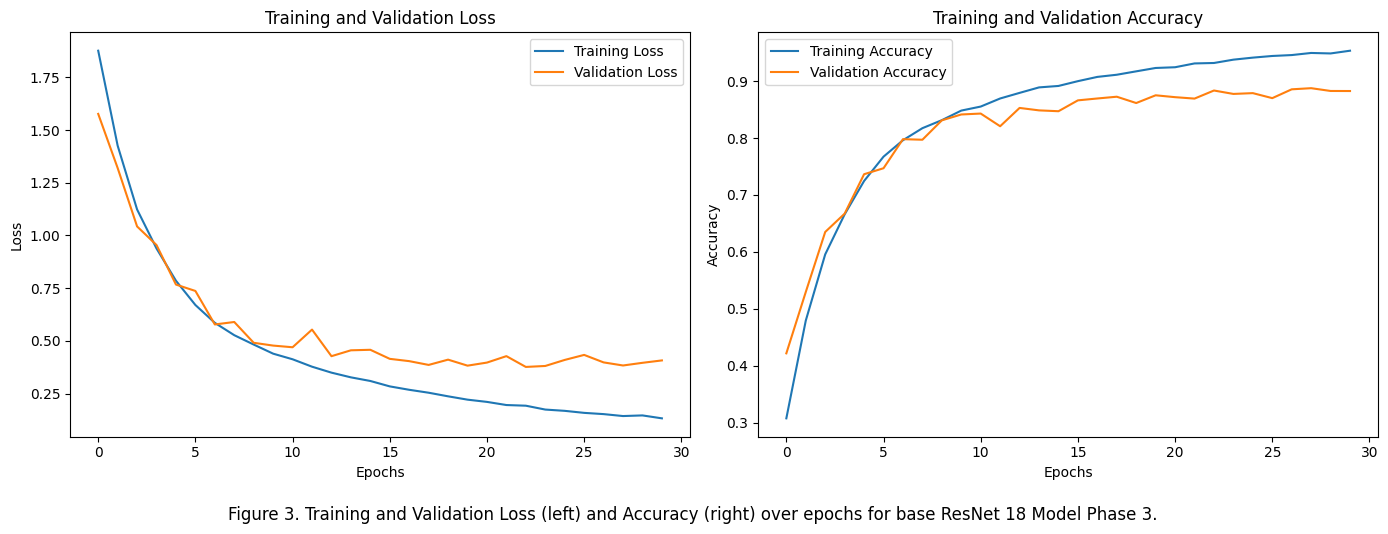

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 3. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 3. ",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_3.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_3.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'optimizer': 'Adam',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_3.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_3.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 4 with Adam optimizer and 0.001 learning rate

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_base_model.parameters(), lr=lr)

epoch_num = 60

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 1.5665, Val Loss: 1.2327, Train Acc: 0.4184, Val Acc: 0.5467
Epoch 2/60, Train Loss: 1.1172, Val Loss: 1.0764, Train Acc: 0.5957, Val Acc: 0.6055
Epoch 3/60, Train Loss: 0.9003, Val Loss: 0.8512, Train Acc: 0.6798, Val Acc: 0.6905
Epoch 4/60, Train Loss: 0.7483, Val Loss: 0.6756, Train Acc: 0.7375, Val Acc: 0.7680
Epoch 5/60, Train Loss: 0.6333, Val Loss: 0.6261, Train Acc: 0.7802, Val Acc: 0.7827
Epoch 6/60, Train Loss: 0.5592, Val Loss: 0.5516, Train Acc: 0.8046, Val Acc: 0.8137
Epoch 7/60, Train Loss: 0.5057, Val Loss: 0.5204, Train Acc: 0.8257, Val Acc: 0.8231
Epoch 8/60, Train Loss: 0.4564, Val Loss: 0.5037, Train Acc: 0.8427, Val Acc: 0.8260
Epoch 9/60, Train Loss: 0.4119, Val Loss: 0.5155, Train Acc: 0.8583, Val Acc: 0.8267
Epoch 10/60, Train Loss: 0.3821, Val Loss: 0.4656, Train Acc: 0.8679, Val Acc: 0.8461
Epoch 11/60, Train Loss: 0.3485, Val Loss: 0.4173, Train Acc: 0.8781, Val Acc: 0.8572
Epoch 12/60, Train Loss: 0.3217, Val Loss: 0.3991, Train Acc: 0

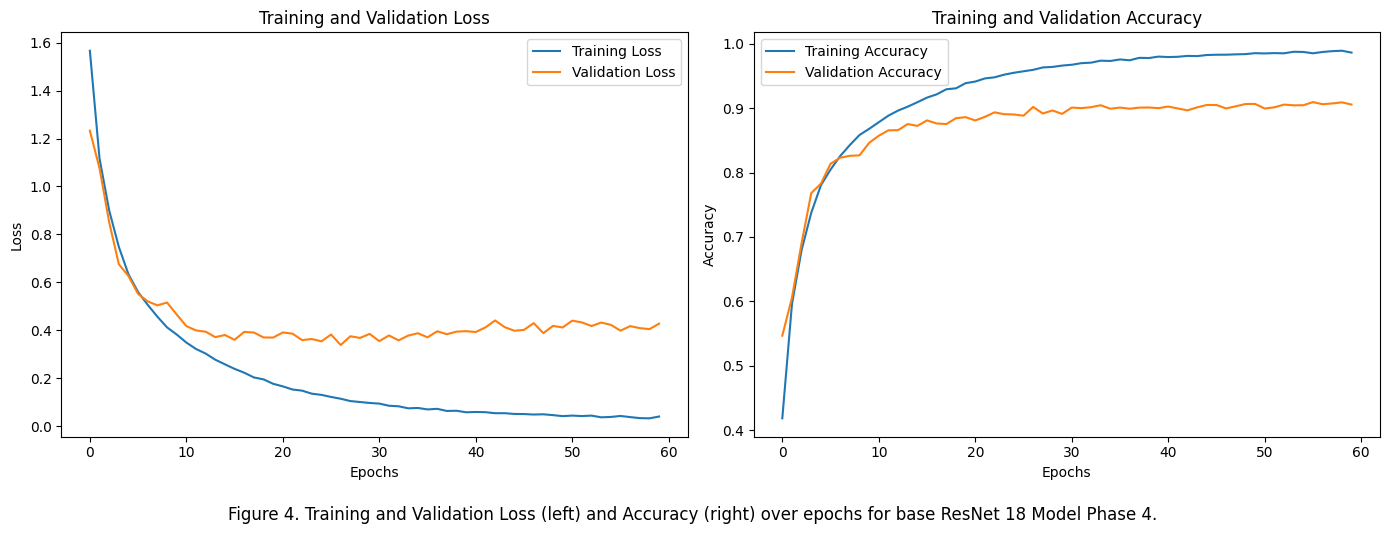

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 4. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 4. ",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_4.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_4.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'optimizer': 'Adam',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_4.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_4.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 5 with AdamW optimizer, 0.01 learning rate and 1e-4 weight decay

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.01
weight_decay= 1e-4 # Weight decay parameter for AdamW
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet18_base_model.parameters(), lr=lr, weight_decay=weight_decay)

epoch_num = 30

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 1.8394, Val Loss: 1.5439, Train Acc: 0.3192, Val Acc: 0.4269
Epoch 2/30, Train Loss: 1.4251, Val Loss: 1.2283, Train Acc: 0.4757, Val Acc: 0.5555
Epoch 3/30, Train Loss: 1.1212, Val Loss: 1.1131, Train Acc: 0.5956, Val Acc: 0.6074
Epoch 4/30, Train Loss: 0.9195, Val Loss: 0.8619, Train Acc: 0.6709, Val Acc: 0.6941
Epoch 5/30, Train Loss: 0.7950, Val Loss: 0.8278, Train Acc: 0.7201, Val Acc: 0.7110
Epoch 6/30, Train Loss: 0.6838, Val Loss: 0.6808, Train Acc: 0.7582, Val Acc: 0.7601
Epoch 7/30, Train Loss: 0.6050, Val Loss: 0.5843, Train Acc: 0.7899, Val Acc: 0.7993
Epoch 8/30, Train Loss: 0.5443, Val Loss: 0.6253, Train Acc: 0.8114, Val Acc: 0.7826
Epoch 9/30, Train Loss: 0.4873, Val Loss: 0.5535, Train Acc: 0.8293, Val Acc: 0.8136
Epoch 10/30, Train Loss: 0.4430, Val Loss: 0.5056, Train Acc: 0.8471, Val Acc: 0.8205
Epoch 11/30, Train Loss: 0.4047, Val Loss: 0.4494, Train Acc: 0.8605, Val Acc: 0.8484
Epoch 12/30, Train Loss: 0.3742, Val Loss: 0.5225, Train Acc: 0

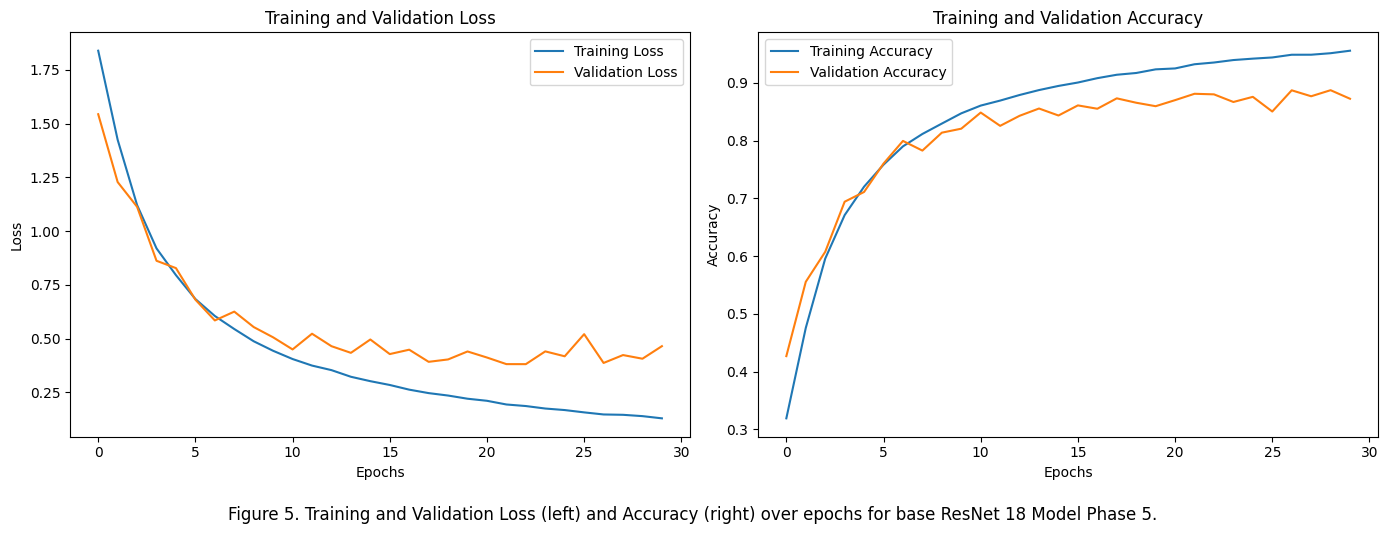

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 5. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 5. ",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_5.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_5.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'weight_decay': weight_decay,
    'optimizer': 'AdamW',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_5.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_5.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 6 with AdamW optimizer, 0.001 learning rate and 1e-4 weight decay

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.001
weight_decay= 1e-4 # Weight decay parameter for AdamW
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet18_base_model.parameters(), lr=lr, weight_decay=weight_decay)

epoch_num = 50

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 1.5392, Val Loss: 1.2798, Train Acc: 0.4326, Val Acc: 0.5426
Epoch 2/50, Train Loss: 1.0795, Val Loss: 1.1933, Train Acc: 0.6120, Val Acc: 0.5917
Epoch 3/50, Train Loss: 0.8791, Val Loss: 0.7916, Train Acc: 0.6879, Val Acc: 0.7232
Epoch 4/50, Train Loss: 0.7288, Val Loss: 0.7605, Train Acc: 0.7442, Val Acc: 0.7362
Epoch 5/50, Train Loss: 0.6246, Val Loss: 0.5860, Train Acc: 0.7807, Val Acc: 0.7994
Epoch 6/50, Train Loss: 0.5465, Val Loss: 0.5743, Train Acc: 0.8113, Val Acc: 0.8007
Epoch 7/50, Train Loss: 0.4927, Val Loss: 0.5858, Train Acc: 0.8290, Val Acc: 0.8019
Epoch 8/50, Train Loss: 0.4484, Val Loss: 0.5546, Train Acc: 0.8449, Val Acc: 0.8068
Epoch 9/50, Train Loss: 0.4055, Val Loss: 0.4597, Train Acc: 0.8603, Val Acc: 0.8437
Epoch 10/50, Train Loss: 0.3718, Val Loss: 0.4682, Train Acc: 0.8704, Val Acc: 0.8437
Epoch 11/50, Train Loss: 0.3406, Val Loss: 0.4317, Train Acc: 0.8805, Val Acc: 0.8569
Epoch 12/50, Train Loss: 0.3153, Val Loss: 0.4103, Train Acc: 0

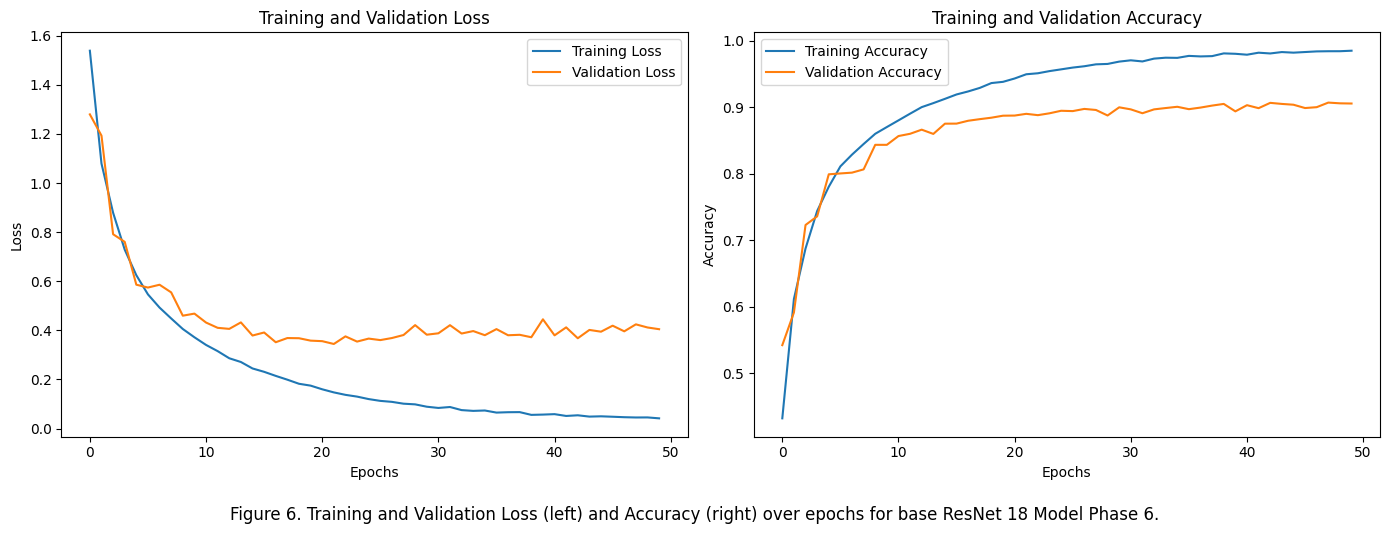

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 6. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 6.",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_6.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_6.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'weight_decay': weight_decay,
    'optimizer': 'AdamW',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_6.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_6.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 7 with Adam optimizer, 0.001 learning rate and 128 batch size

# To define data loaders for training, validation, and testing with 128 batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_base_model.parameters(), lr=lr)

epoch_num = 50

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 1.5562, Val Loss: 1.2274, Train Acc: 0.4278, Val Acc: 0.5576
Epoch 2/50, Train Loss: 1.0882, Val Loss: 1.0979, Train Acc: 0.6064, Val Acc: 0.6166
Epoch 3/50, Train Loss: 0.8866, Val Loss: 0.9126, Train Acc: 0.6849, Val Acc: 0.6820
Epoch 4/50, Train Loss: 0.7368, Val Loss: 0.7308, Train Acc: 0.7422, Val Acc: 0.7465
Epoch 5/50, Train Loss: 0.6374, Val Loss: 0.6561, Train Acc: 0.7775, Val Acc: 0.7754
Epoch 6/50, Train Loss: 0.5615, Val Loss: 0.6097, Train Acc: 0.8042, Val Acc: 0.7844
Epoch 7/50, Train Loss: 0.5001, Val Loss: 0.5775, Train Acc: 0.8259, Val Acc: 0.8025
Epoch 8/50, Train Loss: 0.4566, Val Loss: 0.6224, Train Acc: 0.8418, Val Acc: 0.7929
Epoch 9/50, Train Loss: 0.4202, Val Loss: 0.5857, Train Acc: 0.8523, Val Acc: 0.7983
Epoch 10/50, Train Loss: 0.3795, Val Loss: 0.5390, Train Acc: 0.8691, Val Acc: 0.8203
Epoch 11/50, Train Loss: 0.3556, Val Loss: 0.5098, Train Acc: 0.8759, Val Acc: 0.8341
Epoch 12/50, Train Loss: 0.3266, Val Loss: 0.4394, Train Acc: 0

<function matplotlib.pyplot.show(close=None, block=None)>

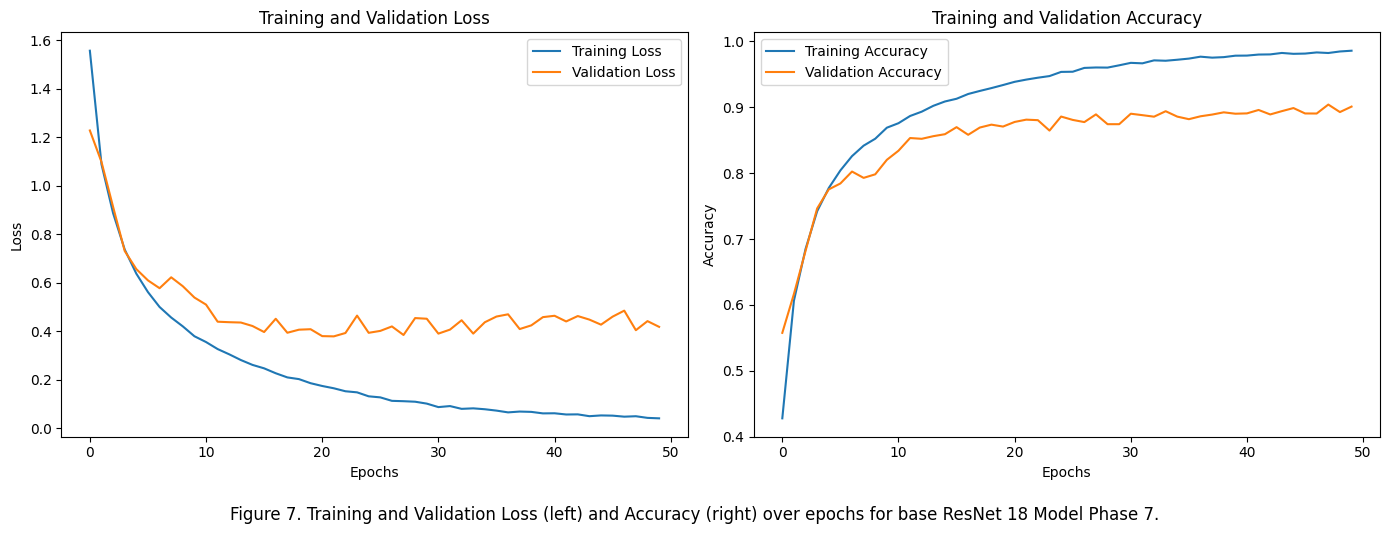

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 7. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 7.",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_7.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_7.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'optimizer': 'Adam',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_7.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_7.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 8 with Adam optimizer, 0.01 learning rate and 128 batch size

# To define data loaders for training, validation, and testing with 128 batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_base_model.parameters(), lr=lr)

epoch_num = 30

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 1.8966, Val Loss: 1.6255, Train Acc: 0.3045, Val Acc: 0.3907
Epoch 2/30, Train Loss: 1.3914, Val Loss: 1.2724, Train Acc: 0.4889, Val Acc: 0.5449
Epoch 3/30, Train Loss: 1.0707, Val Loss: 1.2111, Train Acc: 0.6185, Val Acc: 0.5788
Epoch 4/30, Train Loss: 0.8812, Val Loss: 0.9659, Train Acc: 0.6883, Val Acc: 0.6655
Epoch 5/30, Train Loss: 0.7310, Val Loss: 0.8126, Train Acc: 0.7433, Val Acc: 0.7213
Epoch 6/30, Train Loss: 0.6274, Val Loss: 0.6403, Train Acc: 0.7794, Val Acc: 0.7834
Epoch 7/30, Train Loss: 0.5555, Val Loss: 0.6642, Train Acc: 0.8073, Val Acc: 0.7712
Epoch 8/30, Train Loss: 0.4943, Val Loss: 0.5880, Train Acc: 0.8273, Val Acc: 0.7945
Epoch 9/30, Train Loss: 0.4426, Val Loss: 0.5021, Train Acc: 0.8460, Val Acc: 0.8284
Epoch 10/30, Train Loss: 0.4091, Val Loss: 0.4782, Train Acc: 0.8572, Val Acc: 0.8339
Epoch 11/30, Train Loss: 0.3682, Val Loss: 0.4947, Train Acc: 0.8720, Val Acc: 0.8314
Epoch 12/30, Train Loss: 0.3437, Val Loss: 0.4704, Train Acc: 0

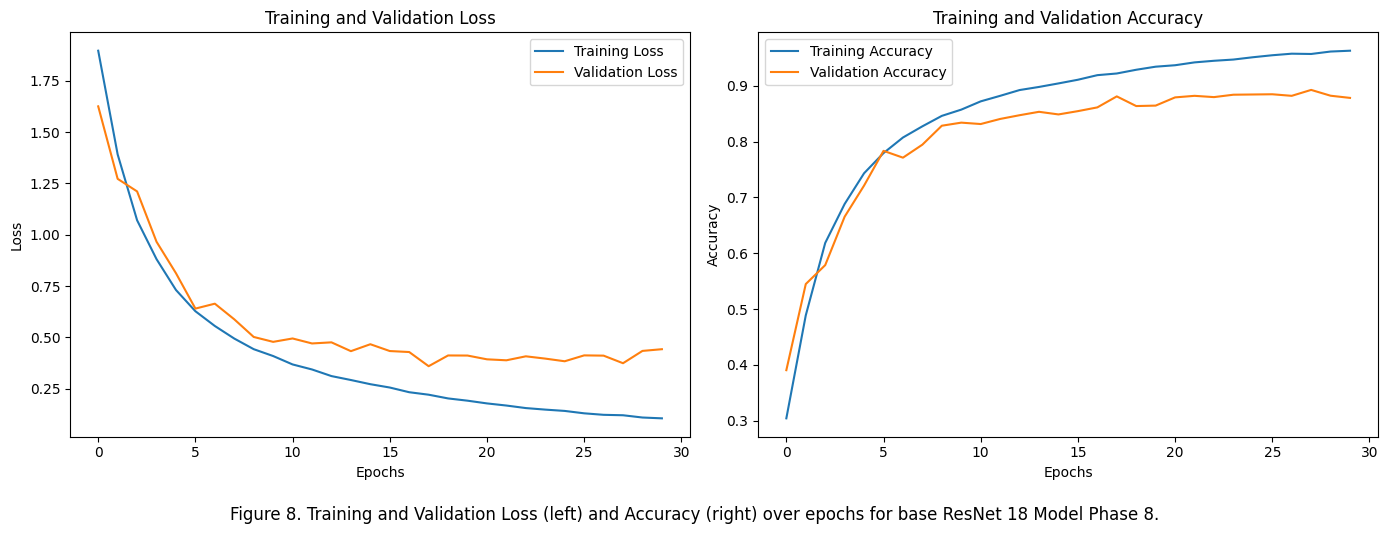

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 8. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 8.",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_8.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_8.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'optimizer': 'Adam',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_8.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_8.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 9 with SGD optimizer, 0.01 learning rate and 0.9 momemtum

# To define data loaders for training, validation, and testing with 64 batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate ResNet 18 model and move it to device
resnet18_base_model = ResNet18().to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_base_model.parameters(), lr=lr, momentum=0.9)

epoch_num = 40

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_base_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_base_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_base_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.4861, Val Loss: 1.3072, Train Acc: 0.4613, Val Acc: 0.5517
Epoch 2/40, Train Loss: 0.9753, Val Loss: 1.0038, Train Acc: 0.6576, Val Acc: 0.6672
Epoch 3/40, Train Loss: 0.7647, Val Loss: 0.8243, Train Acc: 0.7340, Val Acc: 0.7154
Epoch 4/40, Train Loss: 0.6496, Val Loss: 0.6863, Train Acc: 0.7758, Val Acc: 0.7610
Epoch 5/40, Train Loss: 0.5721, Val Loss: 0.6462, Train Acc: 0.8028, Val Acc: 0.7770
Epoch 6/40, Train Loss: 0.5150, Val Loss: 0.5723, Train Acc: 0.8217, Val Acc: 0.8052
Epoch 7/40, Train Loss: 0.4578, Val Loss: 0.5519, Train Acc: 0.8423, Val Acc: 0.8176
Epoch 8/40, Train Loss: 0.4233, Val Loss: 0.5418, Train Acc: 0.8531, Val Acc: 0.8147
Epoch 9/40, Train Loss: 0.3957, Val Loss: 0.5028, Train Acc: 0.8616, Val Acc: 0.8265
Epoch 10/40, Train Loss: 0.3641, Val Loss: 0.4716, Train Acc: 0.8739, Val Acc: 0.8380
Epoch 11/40, Train Loss: 0.3401, Val Loss: 0.4782, Train Acc: 0.8820, Val Acc: 0.8392
Epoch 12/40, Train Loss: 0.3163, Val Loss: 0.4322, Train Acc: 0

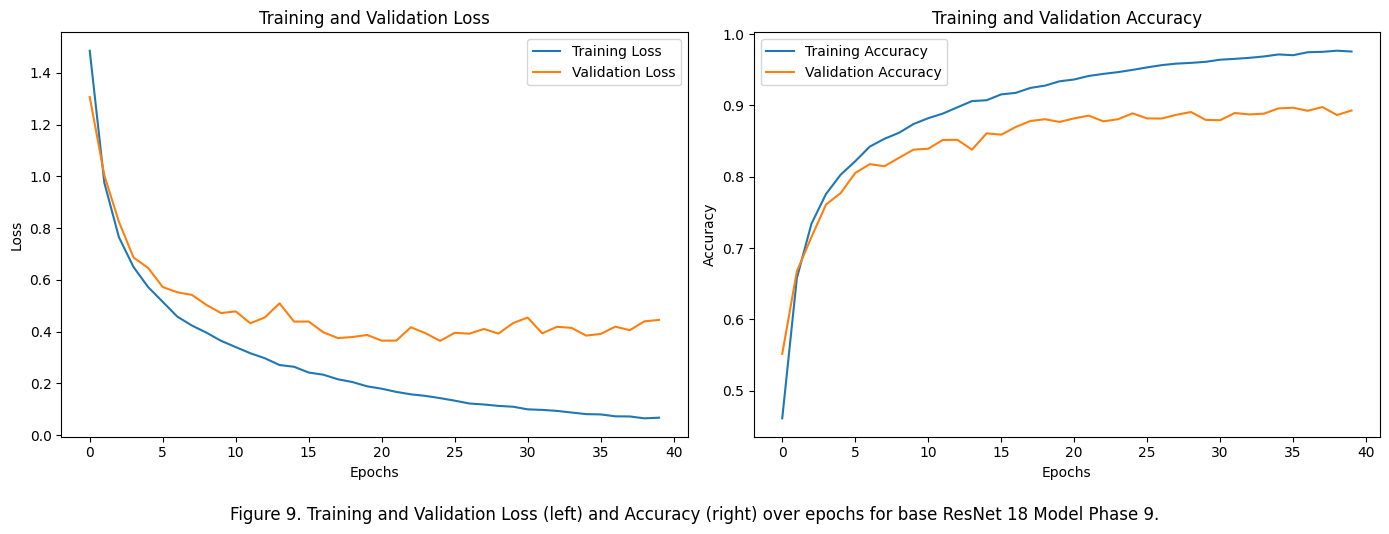

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 9. Training and Validation Loss (left) and Accuracy (right) over epochs for base ResNet 18 Model Phase 9.",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_base_model.state_dict(), 'resnet18_base_9.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_base_metrics_9.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18_Base',
    'learning_rate': lr,
    'optimizer': 'SGD',
    'momentum': 0.9,
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_base_config_9.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_base_final_results_9.json', 'w') as f:
    json.dump(final_results, f)

In [17]:
# Construct ResNet 18 structure and adding dropout layers
# Define the basic residual block used in ResNet18
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define shortcut (residual connection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

# Define ResNet 18 with Dropout
class ResNet18Dropout(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ResNet18Dropout, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Define layers using the BasicBlock
        self.layer1 = self._make_layer(64, 64, stride=1, num_blocks=2)
        self.layer2 = self._make_layer(64, 128, stride=2, num_blocks=2)
        self.layer3 = self._make_layer(128, 256, stride=2, num_blocks=2)
        self.layer4 = self._make_layer(256, 512, stride=2, num_blocks=2)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Global average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolutional layer
        out = self.conv1(x)

        # Residual layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Apply dropout
        out = self.dropout(out)

        # Global average pooling and flatten
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        # Apply dropout before fully connected layer
        out = self.dropout(out)

        # Fully connected layer
        out = self.fc(out)
        return out

# Instantiate ResNet 18 model with Dropout and move it to device
resnet18_dropout_model = ResNet18Dropout(num_classes=10, dropout_rate=0.5).to(device)
print(resnet18_dropout_model)

ResNet18Dropout(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 

In [ ]:
# Training ResNet 18 Model Phase 10 using 0.5 dropout with Adam optimizer and 0.001 learning rate

# Instantiate ResNet 18 model and move it to device
resnet18_dropout_model = ResNet18Dropout(num_classes=10, dropout_rate=0.5).to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_dropout_model.parameters(), lr=lr)

epoch_num = 60

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_dropout_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_dropout_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_dropout_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_dropout_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_dropout_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 1.6250, Val Loss: 1.3353, Train Acc: 0.3963, Val Acc: 0.5183
Epoch 2/60, Train Loss: 1.1528, Val Loss: 1.0579, Train Acc: 0.5848, Val Acc: 0.6203
Epoch 3/60, Train Loss: 0.9478, Val Loss: 0.8960, Train Acc: 0.6634, Val Acc: 0.6798
Epoch 4/60, Train Loss: 0.7898, Val Loss: 0.7279, Train Acc: 0.7223, Val Acc: 0.7443
Epoch 5/60, Train Loss: 0.6810, Val Loss: 0.6750, Train Acc: 0.7643, Val Acc: 0.7688
Epoch 6/60, Train Loss: 0.5982, Val Loss: 0.7243, Train Acc: 0.7960, Val Acc: 0.7551
Epoch 7/60, Train Loss: 0.5390, Val Loss: 0.6071, Train Acc: 0.8179, Val Acc: 0.8006
Epoch 8/60, Train Loss: 0.4874, Val Loss: 0.5159, Train Acc: 0.8353, Val Acc: 0.8268
Epoch 9/60, Train Loss: 0.4512, Val Loss: 0.5368, Train Acc: 0.8468, Val Acc: 0.8182
Epoch 10/60, Train Loss: 0.4122, Val Loss: 0.4843, Train Acc: 0.8576, Val Acc: 0.8352
Epoch 11/60, Train Loss: 0.3868, Val Loss: 0.4336, Train Acc: 0.8674, Val Acc: 0.8525
Epoch 12/60, Train Loss: 0.3586, Val Loss: 0.5194, Train Acc: 0

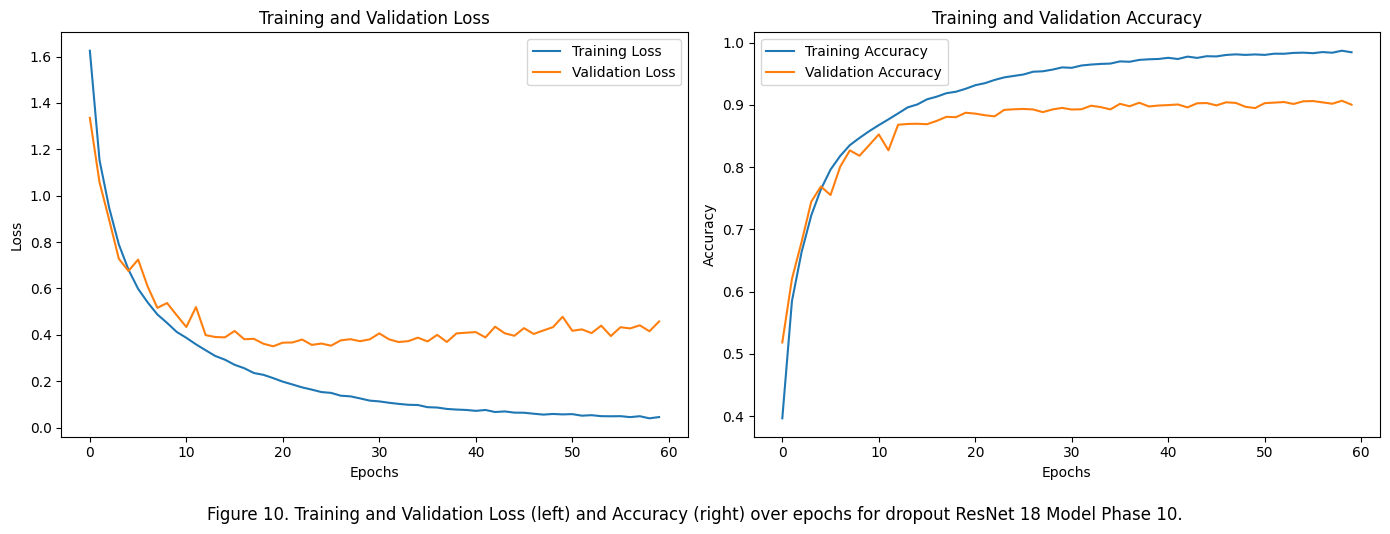

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 10. Training and Validation Loss (left) and Accuracy (right) over epochs for dropout ResNet 18 Model Phase 10.",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_dropout_model.state_dict(), 'resnet18_dropout_10.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_dropout_metrics_10.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18Dropout',
    'learning_rate': lr,
    'optimizer': 'Adam',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_dropout_config_10.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_dropout_final_results_10.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Training ResNet 18 Model Phase 11 using 0.3 dropout with Adam optimizer and 0.001 learning rate

# Instantiate ResNet 18 model and move it to device
resnet18_dropout_model = ResNet18Dropout(num_classes=10, dropout_rate=0.3).to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_dropout_model.parameters(), lr=lr)

epoch_num = 60

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_dropout_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_dropout_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_dropout_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_dropout_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_dropout_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 1.5251, Val Loss: 1.1726, Train Acc: 0.4394, Val Acc: 0.5761
Epoch 2/60, Train Loss: 1.0593, Val Loss: 0.8730, Train Acc: 0.6223, Val Acc: 0.6871
Epoch 3/60, Train Loss: 0.8444, Val Loss: 0.8114, Train Acc: 0.7037, Val Acc: 0.7197
Epoch 4/60, Train Loss: 0.7161, Val Loss: 0.7336, Train Acc: 0.7517, Val Acc: 0.7449
Epoch 5/60, Train Loss: 0.6249, Val Loss: 0.6041, Train Acc: 0.7840, Val Acc: 0.7892
Epoch 6/60, Train Loss: 0.5601, Val Loss: 0.5681, Train Acc: 0.8091, Val Acc: 0.8041
Epoch 7/60, Train Loss: 0.5009, Val Loss: 0.5152, Train Acc: 0.8262, Val Acc: 0.8254
Epoch 8/60, Train Loss: 0.4624, Val Loss: 0.4759, Train Acc: 0.8421, Val Acc: 0.8350
Epoch 9/60, Train Loss: 0.4232, Val Loss: 0.5058, Train Acc: 0.8550, Val Acc: 0.8231
Epoch 10/60, Train Loss: 0.3893, Val Loss: 0.4291, Train Acc: 0.8675, Val Acc: 0.8547
Epoch 11/60, Train Loss: 0.3600, Val Loss: 0.4192, Train Acc: 0.8769, Val Acc: 0.8563
Epoch 12/60, Train Loss: 0.3326, Val Loss: 0.3926, Train Acc: 0

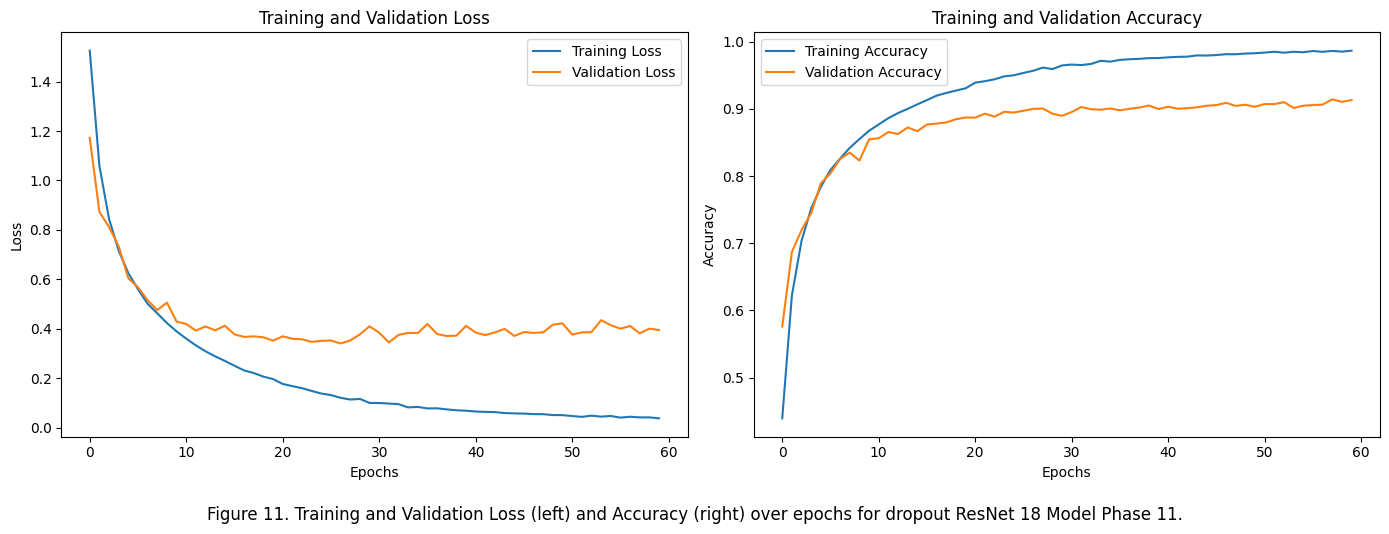

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 11. Training and Validation Loss (left) and Accuracy (right) over epochs for dropout ResNet 18 Model Phase 11.",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_dropout_model.state_dict(), 'resnet18_dropout_11.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_dropout_metrics_11.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18Dropout',
    'learning_rate': lr,
    'optimizer': 'Adam',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_dropout_config_11.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_dropout_final_results_11.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Construct ResNet 18 structure without residual links (no skip connections)
import torch
import torch.nn as nn

# Define the basic block without residual connections
class BasicBlockNoResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockNoResidual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

# Define ResNet-18 without residual connections
class ResNet18NoResidual(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18NoResidual, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Define layers using the BasicBlockNoResidual
        self.layer1 = self._make_layer(64, 64, stride=1, num_blocks=2)
        self.layer2 = self._make_layer(64, 128, stride=2, num_blocks=2)
        self.layer3 = self._make_layer(128, 256, stride=2, num_blocks=2)
        self.layer4 = self._make_layer(256, 512, stride=2, num_blocks=2)

        # Global average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        layers = []
        layers.append(BasicBlockNoResidual(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlockNoResidual(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolutional layer
        out = self.conv1(x)

        # Convolutional layers without residual connections
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Global average pooling and flatten
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        # Fully connected layer
        out = self.fc(out)
        return out

# Instantiate ResNet-18 model without residual links and move it to device
resnet18_no_residual_model = ResNet18NoResidual(num_classes=10).to(device)
print(resnet18_no_residual_model)

ResNet18NoResidual(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlockNoResidual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlockNoResidual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kern

In [ ]:
# Training ResNet 18 without residual links Model Phase 12 with Adam optimizer and 0.001 learning rate

# Instantiate ResNet 18 model and move it to device
resnet18_no_residual_model = ResNet18NoResidual(num_classes=10).to(device)

# Initialize lists to store losses and accuracies for each epoch during the training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define loss function and optimizer
lr= 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_no_residual_model.parameters(), lr=lr)

epoch_num = 60

for epoch in tqdm(range(epoch_num)):
    running_loss = 0.0
    resnet18_no_residual_model.train()
    correct_train, total_train = 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet18_no_residual_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet18_no_residual_model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18_no_residual_model.eval()
    eval_losses = []
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_no_residual_model(inputs)
            loss = criterion(outputs, labels)
            eval_losses.append(loss.item())

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = np.mean(eval_losses)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epoch_num}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60, Train Loss: 1.7440, Val Loss: 1.5640, Train Acc: 0.3350, Val Acc: 0.4108
Epoch 2/60, Train Loss: 1.4036, Val Loss: 1.4204, Train Acc: 0.4801, Val Acc: 0.4891
Epoch 3/60, Train Loss: 1.1643, Val Loss: 1.1976, Train Acc: 0.5800, Val Acc: 0.5573
Epoch 4/60, Train Loss: 1.0030, Val Loss: 0.9893, Train Acc: 0.6411, Val Acc: 0.6512
Epoch 5/60, Train Loss: 0.8915, Val Loss: 0.9520, Train Acc: 0.6816, Val Acc: 0.6651
Epoch 6/60, Train Loss: 0.7928, Val Loss: 0.9554, Train Acc: 0.7215, Val Acc: 0.6768
Epoch 7/60, Train Loss: 0.7151, Val Loss: 0.7253, Train Acc: 0.7538, Val Acc: 0.7479
Epoch 8/60, Train Loss: 0.6521, Val Loss: 0.6448, Train Acc: 0.7733, Val Acc: 0.7797
Epoch 9/60, Train Loss: 0.5995, Val Loss: 0.6065, Train Acc: 0.7934, Val Acc: 0.7867
Epoch 10/60, Train Loss: 0.5532, Val Loss: 0.5754, Train Acc: 0.8098, Val Acc: 0.8030
Epoch 11/60, Train Loss: 0.5094, Val Loss: 0.5086, Train Acc: 0.8250, Val Acc: 0.8244
Epoch 12/60, Train Loss: 0.4800, Val Loss: 0.5370, Train Acc: 0

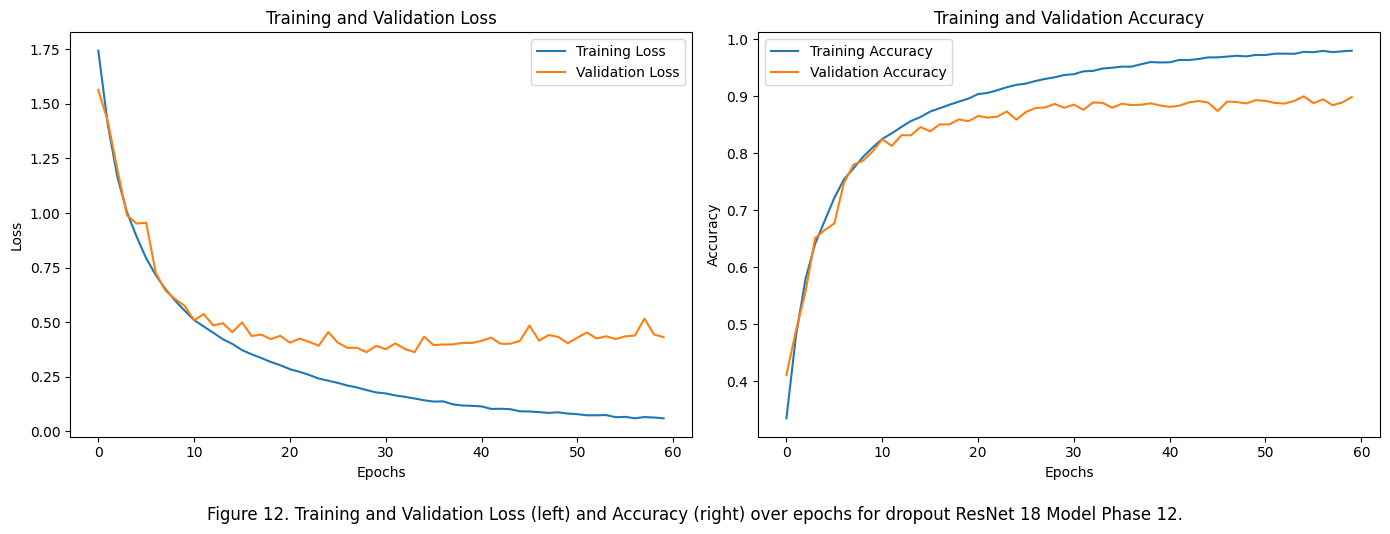

In [ ]:
# To plot Training and Validatio Accuracy and Loss during the traning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add figure text below the plots
fig.text(0.5, -0.05, "Figure 12. Training and Validation Loss (left) and Accuracy (right) over epochs for dropout ResNet 18 Model Phase 12.",
         ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import json

# Saving the Model State Dictionary
torch.save(resnet18_no_residual_model.state_dict(), 'resnet18_no_residual_12.pth')

# Saving Training and Validation Metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
with open('resnet18_no_residual_metrics_12.json', 'w') as f:
    json.dump(metrics, f)

# Saving Configuration and Hyperparameters
config = {
    'model_name': 'ResNet18NoRedidual',
    'learning_rate': lr,
    'optimizer': 'Adam',
    'batch_size': train_loader.batch_size,
    'num_epochs': epoch_num,
    'augmentation': ['RandomCrop(32, padding=4)', 'RandomHorizontalFlip']
}
with open('resnet18_no_residual_config_12.json', 'w') as f:
    json.dump(config, f)

# Save Final Traning and Validation Results for Comparison
final_results = {
    'final_train_loss': train_losses[-1],
    'final_train_accuracy': train_accuracies[-1],
    'final_val_loss': val_losses[-1],
    'final_val_accuracy': val_accuracies[-1]
}
with open('resnet18_no_residual_final_results_12.json', 'w') as f:
    json.dump(final_results, f)

In [ ]:
# Evaluating the best model (resnet18_dropout_11) on the test dataset

import json
import torch

# Load the best saved model weights
resnet18_best_model = ResNet18Dropout(num_classes=10, dropout_rate=0.3).to(device)
resnet18_best_model.load_state_dict(torch.load('resnet18_dropout_11.pth'))
resnet18_best_model.eval()  # Set model to evaluation mode

# Initialize loss function
criterion = nn.CrossEntropyLoss()

# Test the model
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():  # No need to calculate gradients during testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = resnet18_best_model(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

# Calculate final test loss and accuracy
final_test_loss = test_loss / len(test_loader)
final_test_accuracy = correct_test / total_test

# Print test results
print(f"For the best ResNet 18 Model using Adam optimizer with 0.001 learning rate and 0.3 dropout:\nTest Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_accuracy:.4f}")

# Save the test results
test_results = {
    'test_loss': final_test_loss,
    'test_accuracy': final_test_accuracy
}

with open('resnet18_best_model_test_results.json', 'w') as f:
    json.dump(test_results, f)

<ipython-input-21-cdb4936d4a44>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18_best_model.load_state_dict(torch.load('resnet18_dropout_11.pth'))


For the best ResNet 18 Model using Adam optimizer with 0.001 learning rate and 0.3 dropout:
Test Loss: 0.4580, Test Accuracy: 0.9120


In [9]:
# Define some State of the Art models without pretrained weights for comparision with the best model obtained for ResNet 18 (from scratch)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Best hyperparameters obtaind from hyperparameters tuning with ResNet 18
batch_size = 64 # set on train, validatin and test loaders
learning_rate = 0.001 # for Adam optimizer
dropout=0.3
num_epochs = 120
num_classes = 10 # For CIFAR 10

# All model were modified to adapt with the best hyperparameters tuned for the Best model of ResNet 18
# and for the default size of CIFAR 10 images (32x32) since thhat those models were originally disigned
# for ImageNet datase


# Define AlexNet Model
class AlexNetModified(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=dropout):
        super(AlexNetModified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Adjusted kernel size  and stride
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 4 * 4, 4096),  # Adjusted for CIFAR 10 default dimensions
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, num_classes), # last layer with 10 number od classes for Cifar 10
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

alexnet_model = AlexNetModified(num_classes=num_classes, dropout_rate=dropout)

# Define the modified MobileNet V2 Model for CIFAR 10
class MobileNetV2Modified(models.MobileNetV2):
    def __init__(self, num_classes=10, dropout_rate= dropout):
        super(MobileNetV2Modified, self).__init__()
        self.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Adjust stride to 1
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),  # Dropout before the final fully connected layer
            nn.Linear(1280, num_classes),
        )

mobilenet_model = MobileNetV2Modified(num_classes=num_classes, dropout_rate=dropout)

# Define GoogLeNet Model
class GoogLeNetModified(models.GoogLeNet):
    def __init__(self, num_classes=10, dropout_rate=dropout):
        super(GoogLeNetModified, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # Adjusted for 32x32 input
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout before the final fully connected layer
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self._transform_input(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # To apply dropout before the fully connected layer
        x = self.fc(x)
        return x

googlenet_model = GoogLeNetModified(num_classes=num_classes, dropout_rate=dropout)

# Move models to device
models_dict = {
    #"ResNet18": resnet18_dropout_model.to(device),
    "AlexNet": alexnet_model.to(device),
    "MobileNetV2": mobilenet_model.to(device),
    "GoogLeNet": googlenet_model.to(device)
}


Training AlexNet
Epoch [1/120], Train Loss: 1.8087, Train Acc: 31.40%, Val Loss: 1.5368, Val Acc: 42.37%
Epoch [2/120], Train Loss: 1.4733, Train Acc: 46.08%, Val Loss: 1.3535, Val Acc: 50.40%
Epoch [3/120], Train Loss: 1.3076, Train Acc: 52.90%, Val Loss: 1.2381, Val Acc: 55.53%
Epoch [4/120], Train Loss: 1.1768, Train Acc: 58.38%, Val Loss: 1.1383, Val Acc: 59.76%
Epoch [5/120], Train Loss: 1.0838, Train Acc: 61.91%, Val Loss: 0.9900, Val Acc: 65.34%
Epoch [6/120], Train Loss: 1.0161, Train Acc: 64.47%, Val Loss: 1.0087, Val Acc: 64.14%
Epoch [7/120], Train Loss: 0.9682, Train Acc: 66.07%, Val Loss: 0.9470, Val Acc: 66.90%
Epoch [8/120], Train Loss: 0.9203, Train Acc: 68.11%, Val Loss: 0.8929, Val Acc: 69.44%
Epoch [9/120], Train Loss: 0.8854, Train Acc: 69.20%, Val Loss: 0.8558, Val Acc: 70.02%
Epoch [10/120], Train Loss: 0.8661, Train Acc: 69.84%, Val Loss: 0.8619, Val Acc: 70.15%
Epoch [11/120], Train Loss: 0.8397, Train Acc: 71.34%, Val Loss: 0.8475, Val Acc: 71.18%
Epoch [12/12

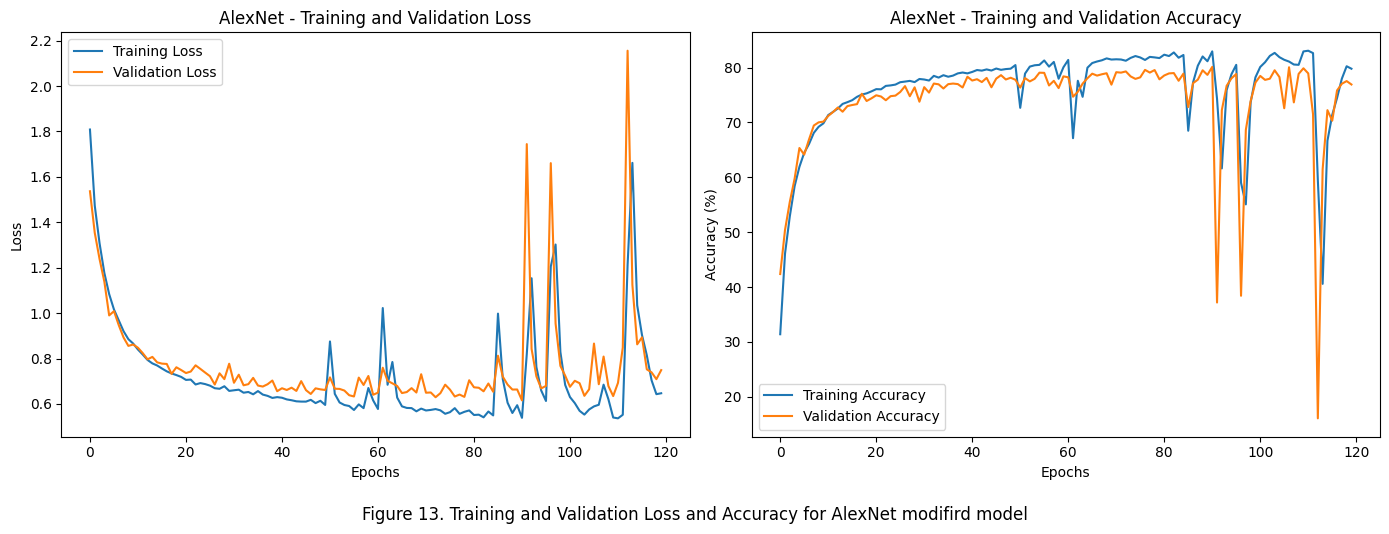


Training MobileNetV2
Epoch [1/120], Train Loss: 1.8421, Train Acc: 30.93%, Val Loss: 1.7275, Val Acc: 37.50%
Epoch [2/120], Train Loss: 1.4776, Train Acc: 46.38%, Val Loss: 1.3847, Val Acc: 50.62%
Epoch [3/120], Train Loss: 1.2941, Train Acc: 53.43%, Val Loss: 1.3336, Val Acc: 53.46%
Epoch [4/120], Train Loss: 1.1513, Train Acc: 59.08%, Val Loss: 1.0622, Val Acc: 62.07%
Epoch [5/120], Train Loss: 1.0200, Train Acc: 63.60%, Val Loss: 0.9589, Val Acc: 66.15%
Epoch [6/120], Train Loss: 0.9197, Train Acc: 67.67%, Val Loss: 0.8706, Val Acc: 69.41%
Epoch [7/120], Train Loss: 0.8282, Train Acc: 71.15%, Val Loss: 0.7919, Val Acc: 72.93%
Epoch [8/120], Train Loss: 0.7586, Train Acc: 73.59%, Val Loss: 0.7722, Val Acc: 73.32%
Epoch [9/120], Train Loss: 0.7157, Train Acc: 75.43%, Val Loss: 0.7332, Val Acc: 74.65%
Epoch [10/120], Train Loss: 0.6736, Train Acc: 76.94%, Val Loss: 0.6785, Val Acc: 76.29%
Epoch [11/120], Train Loss: 0.6388, Train Acc: 77.99%, Val Loss: 0.6504, Val Acc: 78.05%
Epoch [1

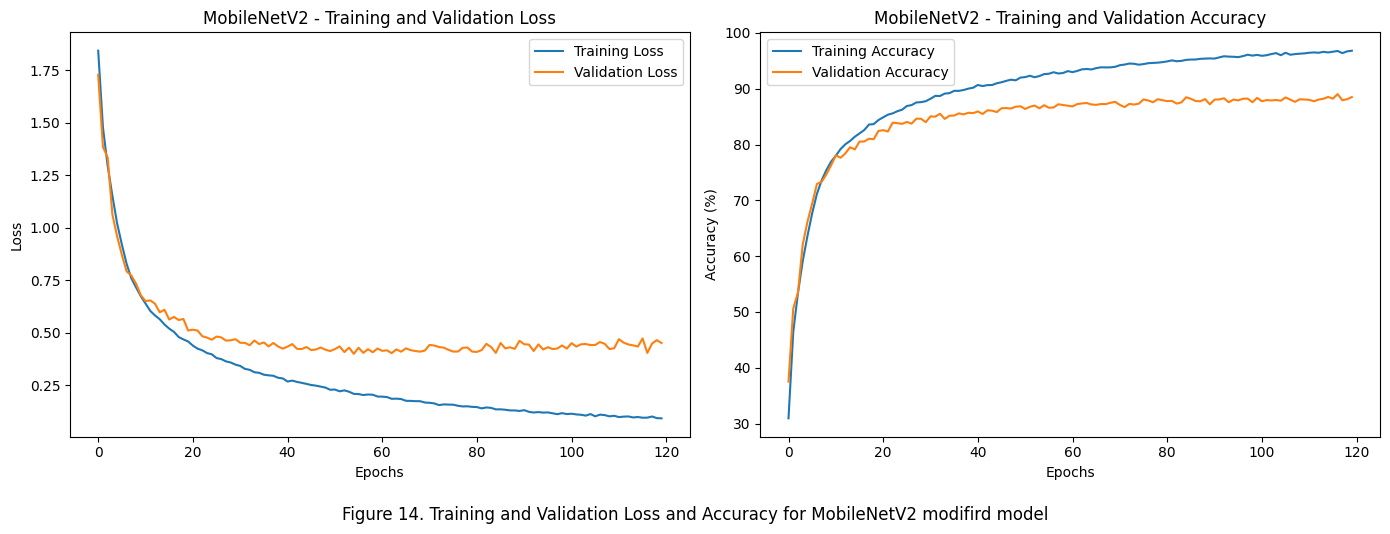


Training GoogLeNet
Epoch [1/120], Train Loss: 1.6070, Train Acc: 40.37%, Val Loss: 1.3948, Val Acc: 50.19%
Epoch [2/120], Train Loss: 1.1844, Train Acc: 57.56%, Val Loss: 1.1236, Val Acc: 60.04%
Epoch [3/120], Train Loss: 0.9985, Train Acc: 64.79%, Val Loss: 0.9350, Val Acc: 67.26%
Epoch [4/120], Train Loss: 0.8572, Train Acc: 70.00%, Val Loss: 0.9285, Val Acc: 67.03%
Epoch [5/120], Train Loss: 0.7551, Train Acc: 74.00%, Val Loss: 0.8710, Val Acc: 71.14%
Epoch [6/120], Train Loss: 0.6624, Train Acc: 77.25%, Val Loss: 0.7155, Val Acc: 75.34%
Epoch [7/120], Train Loss: 0.5984, Train Acc: 79.68%, Val Loss: 0.6733, Val Acc: 77.13%
Epoch [8/120], Train Loss: 0.5511, Train Acc: 81.14%, Val Loss: 0.5886, Val Acc: 79.87%
Epoch [9/120], Train Loss: 0.5047, Train Acc: 82.59%, Val Loss: 0.5300, Val Acc: 82.04%
Epoch [10/120], Train Loss: 0.4693, Train Acc: 83.83%, Val Loss: 0.6006, Val Acc: 79.33%
Epoch [11/120], Train Loss: 0.4315, Train Acc: 85.08%, Val Loss: 0.5733, Val Acc: 80.85%
Epoch [12/

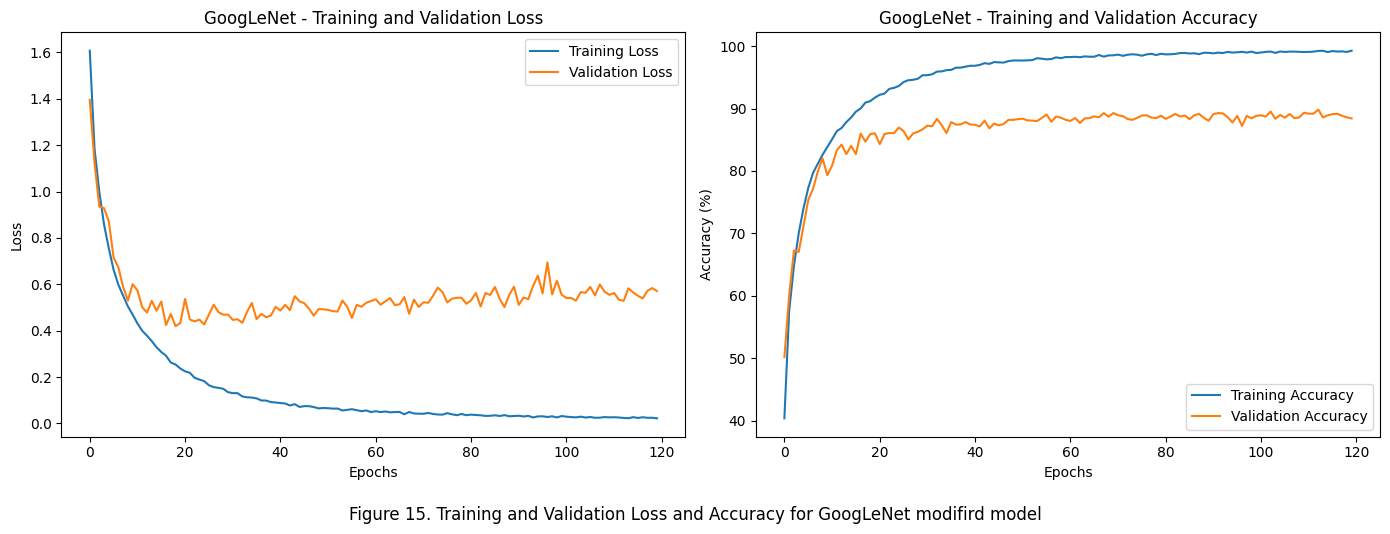

In [10]:
# Train and validate the four models and store their results for comparison
# Loss function and optimizer setup
criterion = nn.CrossEntropyLoss()

# Training and validation function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss /len(train_loader.dataset)
        train_accuracy = 100* correct/ total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss_val, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss_val / len(val_loader.dataset)
        val_accuracy = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Define a dictionary to store training and validation results
results = {}
fig_num = 13

# Train and validate each model
for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Train and validate, storing the results
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )

    # Store results in the dictionary
    results[model_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    # Plot Training and Validation Loss and Accuracy for the current model
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title(f"{model_name} - Training and Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot Accuracy
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title(f"{model_name} - Training and Validation Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()

    # Add figure text below the plots for each model
    fig.text(0.5, -0.05, f"Figure {fig_num}. Training and Validation Loss and Accuracy for {model_name} modifird model",
             ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
    fig_num+=1


In [11]:
# To save the three trained models and their results
import torch
import json
import os

# Directory to save models and results
save_dir = "model_saves"
os.makedirs(save_dir, exist_ok=True)

# Loop through each model to save weights and metrics
for model_name, model in models_dict.items():
    # Saving the Model State Dictionary
    model_path = os.path.join(save_dir, f"{model_name}_state_dict.pth")
    torch.save(model.state_dict(), model_path)
    print(f"{model_name} weights saved to {model_path}")

    # Saving Training and Validation Metrics
    metrics = {
        'train_losses': results[model_name]['train_losses'],
        'val_losses': results[model_name]['val_losses'],
        'train_accuracies': results[model_name]['train_accuracies'],
        'val_accuracies': results[model_name]['val_accuracies']
    }
    metrics_path = os.path.join(save_dir, f"{model_name}_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)
    print(f"{model_name} metrics saved to {metrics_path}")

    # Saving Final Training and Validation Results
    final_results = {
        'final_train_loss': results[model_name]['train_losses'][-1],
        'final_train_accuracy': results[model_name]['train_accuracies'][-1],
        'final_val_loss': results[model_name]['val_losses'][-1],
        'final_val_accuracy': results[model_name]['val_accuracies'][-1]
    }
    final_results_path = os.path.join(save_dir, f"{model_name}_final_results.json")
    with open(final_results_path, 'w') as f:
        json.dump(final_results, f)
    print(f"{model_name} final results saved to {final_results_path}")

AlexNet weights saved to model_saves/AlexNet_state_dict.pth
AlexNet metrics saved to model_saves/AlexNet_metrics.json
AlexNet final results saved to model_saves/AlexNet_final_results.json
MobileNetV2 weights saved to model_saves/MobileNetV2_state_dict.pth
MobileNetV2 metrics saved to model_saves/MobileNetV2_metrics.json
MobileNetV2 final results saved to model_saves/MobileNetV2_final_results.json
GoogLeNet weights saved to model_saves/GoogLeNet_state_dict.pth
GoogLeNet metrics saved to model_saves/GoogLeNet_metrics.json
GoogLeNet final results saved to model_saves/GoogLeNet_final_results.json


In [12]:
# Evalute the three models on the test dataset

import torch
import torch.nn as nn

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Function to evaluate model on the test set
def test_model(model, model_name, test_loader, device):
    model.eval()  # Set to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 *correct / total
    print(f"{model_name} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy

# Directory where models are saved
save_dir = "model_saves"

# Evaluate the saved models on the test set
for model_name, model in models_dict.items():
    # Load the model weights
    model_path = os.path.join(save_dir, f"{model_name}_state_dict.pth")
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    print(f"\nEvaluating {model_name} on the test set: ")

    # Evaluate on the test set
    test_loss, test_accuracy = test_model(model, model_name, test_loader, device)

    # To save the test results for later comparison
    test_results_path = os.path.join(save_dir, f"{model_name}_test_results.json")
    test_results = {
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    with open(test_results_path, 'w') as f:
        json.dump(test_results, f)
    print(f"{model_name} test results saved to {test_results_path}")

<ipython-input-12-a5f31a034c9d>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Evaluating AlexNet on the test set: 
AlexNet - Test Loss: 0.7041, Test Accuracy: 78.81%
AlexNet test results saved to model_saves/AlexNet_test_results.json

Evaluating MobileNetV2 on the test set: 
MobileNetV2 - Test Loss: 0.4572, Test Accuracy: 88.67%
MobileNetV2 test results saved to model_saves/MobileNetV2_test_results.json

Evaluating GoogLeNet on the test set: 
GoogLeNet - Test Loss: 0.6024, Test Accuracy: 88.83%
GoogLeNet test results saved to model_saves/GoogLeNet_test_results.json


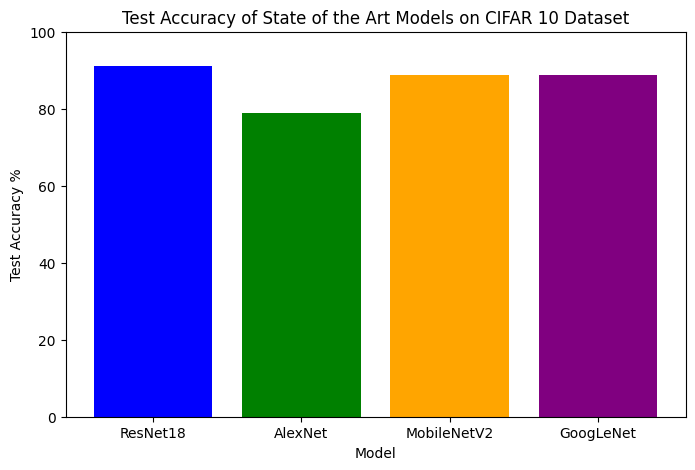

In [15]:
# Compare the Best ResNet 18 models with different State of the Art networks

import matplotlib.pyplot as plt

# To visualize test accuracy results for different models
model_names = ['ResNet18', 'AlexNet', 'MobileNetV2', 'GoogLeNet']
test_accuracies = [91.20, 78.81, 88.67, 88.83]

plt.figure(figsize=(8, 5))
plt.bar(model_names, test_accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy %')
plt.title('Test Accuracy of State of the Art Models on CIFAR 10 Dataset')
plt.ylim(0, 100)
plt.show()

In [20]:
# Calculate per-class accuracies for all models for comparison

import numpy as np

# Inistantiate The best hyper parameters tuned ResNet18 model with dropout
resnet18_dropout_model = ResNet18Dropout(num_classes=num_classes, dropout_rate=dropout)

# Move models to device
models_dict = {
    "ResNet18": resnet18_dropout_model.to(device),
    "AlexNet": alexnet_model.to(device),
    "MobileNetV2": mobilenet_model.to(device),
    "GoogLeNet": googlenet_model.to(device)
}

# Function to calculate per-class accuracy
def per_class_accuracy(model, model_name, test_loader, device, num_classes=10):
    model.eval()
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(labels)):
                label = labels[i].item()
                if predicted[i] == label:
                    class_correct[label] += 1
                class_total[label] += 1

    # Calculate accuracy for each class
    class_accuracies = 100 * class_correct / class_total
    for i in range(num_classes):
        print(f"{model_name} - Accuracy for class {i}: {class_accuracies[i]:.2f}%")

    return class_accuracies

# Dictionary to store per-class accuracy for each model
per_class_accuracies ={}

# To evaluate each model for per-class accuracy
for model_name, model in models_dict.items():
    # Load the model weights
    model_path = os.path.join(save_dir, f"{model_name}_state_dict.pth")
    model.load_state_dict(torch.load(model_path))
    model.to(device)  # Move model to the appropriate device

    # Calculate per-class accuracy
    print(f"\nPer-class accuracy for {model_name}: ")
    class_accuracies = per_class_accuracy(model, model_name, test_loader, device, num_classes)
    per_class_accuracies[model_name] = class_accuracies

<ipython-input-20-84c48cdf89dd>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Per-class accuracy for ResNet18: 
ResNet18 - Accuracy for class 0: 91.70%
ResNet18 - Accuracy for class 1: 97.00%
ResNet18 - Accuracy for class 2: 88.50%
ResNet18 - Accuracy for class 3: 77.80%
ResNet18 - Accuracy for class 4: 92.30%
ResNet18 - Accuracy for class 5: 86.10%
ResNet18 - Accuracy for class 6: 95.90%
ResNet18 - Accuracy for class 7: 92.70%
ResNet18 - Accuracy for class 8: 95.90%
ResNet18 - Accuracy for class 9: 94.10%

Per-class accuracy for AlexNet: 
AlexNet - Accuracy for class 0: 90.30%
AlexNet - Accuracy for class 1: 92.00%
AlexNet - Accuracy for class 2: 72.60%
AlexNet - Accuracy for class 3: 46.90%
AlexNet - Accuracy for class 4: 73.30%
AlexNet - Accuracy for class 5: 70.00%
AlexNet - Accuracy for class 6: 83.30%
AlexNet - Accuracy for class 7: 87.30%
AlexNet - Accuracy for class 8: 83.20%
AlexNet - Accuracy for class 9: 89.20%

Per-class accuracy for MobileNetV2: 
MobileNetV2 - Accuracy for class 0: 93.80%
MobileNetV2 - Accuracy for class 1: 94.30%
MobileNetV2 - Acc

**References:**

https://github.com/kuangliu/pytorch-cifar/tree/master/models

https://pytorch.org/

https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
